In [1]:
import pandas as pd
import sklearn as sk
import geopy.distance
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trips_df = pd.read_csv("citibike-trips.csv")

In [3]:
trips_df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,customer_plan
0,2319,2016-03-09 13:08:21,2016-03-09 13:47:01,520,W 52 St & 5 Ave,40.759923,-73.976485,363,West Thames St,40.708347,-74.017134,23062,Subscriber,1972.0,male,NaN
1,313,2015-07-09 15:42:30,2015-07-09 15:47:44,520,W 52 St & 5 Ave,40.759923,-73.976485,493,W 45 St & 6 Ave,40.756800,-73.982912,16909,Subscriber,1968.0,female,NaN
2,798,2017-04-20 18:43:59,2017-04-20 18:57:17,520,W 52 St & 5 Ave,40.759923,-73.976485,3258,W 27 St & 10 Ave,40.750182,-74.002184,15555,Subscriber,1991.0,male,NaN
3,3100,2017-04-23 15:23:46,2017-04-23 16:15:26,520,W 52 St & 5 Ave,40.759923,-73.976485,281,Grand Army Plaza & Central Park S,40.764397,-73.973715,20648,Customer,NaN,unknown,NaN
4,906,2016-01-11 18:32:33,2016-01-11 18:47:39,520,W 52 St & 5 Ave,40.759923,-73.976485,3162,W 78 St & Broadway,40.783400,-73.980931,15614,Subscriber,1961.0,male,NaN


In [4]:
trips_df["birth_year"].isna().value_counts() ## 55K trips have users with unknown birth year 

False    417581
True      55975
Name: birth_year, dtype: int64

In [5]:
trips_df["gender"].value_counts() ## 56K users with unknown gender 

male       315807
female     100871
unknown     56878
Name: gender, dtype: int64

In [6]:
trips_df["customer_plan"].isna().value_counts() ## idk what this attribute is

True    473556
Name: customer_plan, dtype: int64

## Cleaning the Trips Data
TODO: Transform all columns into numeric data that's useful for classification

In [7]:
# idea for starttime, stoptime, is to see maybe WHEN most rides are initiated

In [8]:
hour_start = []
for i in range(len(trips_df["starttime"])):
    start_hour = trips_df["starttime"].iloc[i][11:13]
    if start_hour[0] == "0":
        hour_start.append(start_hour[1])
    else:
        hour_start.append(start_hour)

In [9]:
trips_df["hour_start"] = hour_start # we've now made an ordinal variable so we can classify the time of day when a trip starts

In [10]:
# idea for start station, end station, is to calculate distance of trip
trip_dist = []

for i in range(len(trips_df)):
    start_long = trips_df["start_station_longitude"].iloc[i]
    start_lat = trips_df["start_station_latitude"].iloc[i]
    end_long = trips_df["end_station_longitude"].iloc[i]
    end_lat = trips_df["end_station_latitude"].iloc[i]
    
    trip_dist.append(geopy.distance.geodesic((start_lat, start_long), (end_lat, end_long)).km) # using kilometers

In [11]:
trips_df["distance_traveled"] = trip_dist

In [12]:
# idea for usertype, one-hot encode whether or not the user is a subscriber
# 1 for yes, 0 for no.
# subscriber means that the user has an annual pass to use Citibike
# customer means that the user purchaed a 24- or 3-hour pass

is_subscriber = []

for i in range(len(trips_df)):
    if trips_df["usertype"].iloc[i] == "Subscriber":
        is_subscriber.append(1)
    else:
        is_subscriber.append(0)

In [13]:
trips_df["is_subscriber"] = is_subscriber

In [14]:
# problem with avg birth year is that there are many null values
# for now, assume that the users w/ no birth year (likely because they aren't subscribers)
# have the avg birth year of the users who do have their birth years recorded

In [15]:
avg_birth_year = trips_df["birth_year"].mean()

In [16]:
trips_df["birth_year"] = trips_df["birth_year"].fillna(avg_birth_year)

In [17]:
# for gender, one-hot encode male/female binary
# 1 for female, 0 for male
# my implementation of this assumes that gender-unknown users are male, though they are likely
# some other gender or have some % of female

is_female = []
for i in range(len(trips_df)):
    if trips_df["gender"].iloc[i] == "female":
        is_female.append(1)
    else:
        is_female.append(0)

In [18]:
trips_df["is_female"] = is_female

In [19]:
trips_df_cleaned = trips_df[["tripduration", "birth_year", "hour_start", "distance_traveled", "is_subscriber", "is_female"]] # just the numerical variables

In [20]:
trips_df_cleaned

,tripduration,birth_year,hour_start,distance_traveled,is_subscriber,is_female
0,2319,1972.000000,13,6.677860,1,0
1,313,1968.000000,15,0.643981,1,1
2,798,1991.000000,18,2.424841,1,0
3,3100,1977.377694,15,0.549202,0,0
4,906,1961.000000,18,2.634014,1,0
...,...,...,...,...,...,...
473551,1368,1950.000000,16,1.743683,1,1
473552,1283,1977.377694,12,3.642224,0,0
473553,620,1977.377694,15,1.782790,0,0
473554,1510,1977.377694,15,3.260764,0,0


In [21]:
hour_start_int = pd.to_numeric(trips_df_cleaned["hour_start"])
trips_df_cleaned["hour_start"] = hour_start_int

C:\Users\matth\AppData\Local\Temp\ipykernel_19156\3364991026.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trips_df_cleaned["hour_start"] = hour_start_int


In [22]:
# now applying MinMax Scaling
scaler = MinMaxScaler()
scaler.fit(trips_df_cleaned)
trips_df_cleaned_scaled = pd.DataFrame(scaler.transform(trips_df_cleaned))

## trying some clustering techniques

In [23]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=10).fit(trips_df_cleaned_scaled)
    trips_df_cleaned_scaled["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\matth\anaconda3\lib

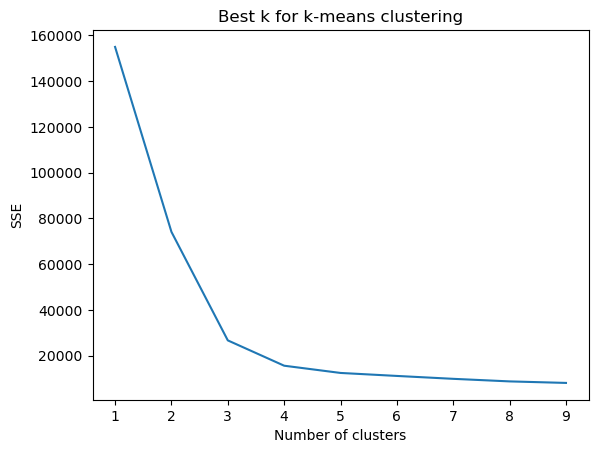

In [25]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("Best k for k-means clustering")
plt.savefig("elbow.png")
plt.show()

## running on smaller subset of data

In [27]:
trips_df_cleaned_scaled

,0,1,2,3,4,5,clusters
0,0.001147,0.750000,0.565217,0.000770,1.0,0.0,3
1,0.000128,0.715517,0.652174,0.000074,1.0,1.0,1
2,0.000375,0.913793,0.782609,0.000280,1.0,0.0,5
3,0.001543,0.796359,0.652174,0.000063,0.0,0.0,7
4,0.000430,0.655172,0.782609,0.000304,1.0,0.0,0
...,...,...,...,...,...,...,...
473551,0.000664,0.560345,0.695652,0.000201,1.0,1.0,1
473552,0.000621,0.796359,0.521739,0.000420,0.0,0.0,6
473553,0.000284,0.796359,0.652174,0.000206,0.0,0.0,7
473554,0.000736,0.796359,0.652174,0.000376,0.0,0.0,7


In [28]:
no_distances = trips_df_cleaned_scaled.drop(columns = [3, "clusters"])

In [29]:
no_distances_has_labels = trips_df_cleaned_scaled.drop(columns = 3)

In [30]:
kmeans = KMeans(n_clusters=3, max_iter=10).fit(no_distances)
kmeans.cluster_centers_

array([[3.59351987e-04, 7.92674942e-01, 6.03907433e-01, 1.00000000e+00,
        7.05269176e-14],
       [4.22543868e-04, 8.06380890e-01, 6.04518082e-01, 1.00000000e+00,
        1.00000000e+00],
       [9.92138685e-04, 7.99333770e-01, 6.30002178e-01, 8.11573031e-14,
        2.28076937e-02]])

In [50]:
trips_df["labels"] = kmeans.labels_

In [91]:
len(label_2)

57086

In [71]:
label_0 = trips_df[trips_df["labels"] == 0]
label_0["hour_start"] = label_0["hour_start"].astype(float)
label_0_mean = label_0[["tripduration", "birth_year", "hour_start", "is_subscriber", "is_female"]].mean()

C:\Users\matth\AppData\Local\Temp\ipykernel_19156\704529197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_0["hour_start"] = label_0["hour_start"].astype(float)


In [73]:
label_0_mean

tripduration      767.810578
birth_year       1976.950293
hour_start         13.889871
is_subscriber       1.000000
is_female           0.000000
dtype: float64

In [77]:
label_1 = trips_df[trips_df["labels"] == 1]
label_1["hour_start"] = label_1["hour_start"].astype(float)
label_1_mean = label_1[["tripduration", "birth_year", "hour_start", "is_subscriber", "is_female"]].mean()

C:\Users\matth\AppData\Local\Temp\ipykernel_19156\2512063200.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_1["hour_start"] = label_1["hour_start"].astype(float)


In [78]:
label_2 = trips_df[trips_df["labels"] == 2]
label_2["hour_start"] = label_2["hour_start"].astype(float)
label_2_mean = label_2[["tripduration", "birth_year", "hour_start", "is_subscriber", "is_female"]].mean()

C:\Users\matth\AppData\Local\Temp\ipykernel_19156\3579993467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_2["hour_start"] = label_2["hour_start"].astype(float)


In [81]:
test0 = pd.DataFrame(label_0_mean)
test1 = pd.DataFrame(label_1_mean)
test2 = pd.DataFrame(label_2_mean)

all_avg = pd.concat([test0, test1, test2], axis = 1)

In [83]:
all_avg.columns = ["cluster_0", "cluster_1", "cluster_2"]

In [86]:
all_avg_t = all_avg.T

In [89]:
print(all_avg_t.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  tripduration &   birth\_year &  hour\_start &  is\_subscriber &  is\_female \\
\midrule
cluster\_0 &    767.810578 &  1976.950293 &   13.889871 &            1.0 &   0.000000 \\
cluster\_1 &    892.278741 &  1978.540183 &   13.903916 &            1.0 &   1.000000 \\
cluster\_2 &   2014.201678 &  1977.722717 &   14.490050 &            0.0 &   0.022808 \\
\bottomrule
\end{tabular}



C:\Users\matth\AppData\Local\Temp\ipykernel_19156\293102242.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_avg_t.to_latex())


In [49]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
cluster_centers.columns = ["tripduration", "birth_year", "hour_start", "is_subscriber", "is_female"]
print(cluster_centers.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  tripduration &  birth\_year &  hour\_start &  is\_subscriber &     is\_female \\
\midrule
0 &      0.000359 &    0.792675 &    0.603907 &   1.000000e+00 &  7.052692e-14 \\
1 &      0.000423 &    0.806381 &    0.604518 &   1.000000e+00 &  1.000000e+00 \\
2 &      0.000992 &    0.799334 &    0.630002 &   8.115730e-14 &  2.280769e-02 \\
\bottomrule
\end{tabular}



C:\Users\matth\AppData\Local\Temp\ipykernel_19156\3064159860.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(cluster_centers.to_latex())


In [31]:
## print(metrics.silhouette_score(no_distances, no_distances_has_labels["clusters"], metric = "euclidean"))

KeyboardInterrupt: 